In [42]:
!pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cpu


[notice] A new release of pip available: 22.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
import os, math, time, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from fractions import Fraction
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import gaussian_filter


In [44]:
# ------------- Config -------------
SEED          = 42
SIDE          = 96
TRAIN_SAMPLES = 8000
VAL_SAMPLES   = 1000
EPOCHS        = 20
BATCH_SIZE    = 64
LR            = 1e-3
WEIGHT_DECAY  = 1e-4

# 학습할 각진동수 비(원하면 여러 개 넣어도 됨)
RATIOS        = [(1,3)]

# 합성 난이도 (폭 좁/넓/약간 기울어진 그림까지 커버)
THICKNESS_PX  = (1, 4)
GRID_PROB     = 0.6
NOISE_STD     = (0, 10)
ROT_JIT_DEG   = (-10, 10)     # 추론 때는 꺼도 됨
SCALE_JIT     = (0.90, 1.10)

In [45]:
# ---------------- Utils (revised) ----------------
def set_seed(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)

def delta_to_pi_fraction(delta_rad, max_den=180):
    r = float(delta_rad % (2*np.pi)) / np.pi
    frac = Fraction(r).limit_denominator(max_den)
    k, n = frac.numerator, frac.denominator
    return "0" if k==0 else (f"{k}π" if n==1 else f"{k}π/{n}")

def lissajous_points(a,b,delta,n=1500,tmax=2*np.pi, Ax=1.0, Ay=1.0):
    t = np.linspace(0, tmax, n, dtype=np.float32)
    x = Ax*np.sin(a*t + delta); y = Ay*np.sin(b*t)
    return x, y

def draw_curve(size, a, b, delta, thickness=2, margin=0.06, Ax=1.0, Ay=1.0):
    img = Image.new('L', (size, size), 255)
    draw = ImageDraw.Draw(img)
    x, y = lissajous_points(a,b,delta, Ax=Ax, Ay=Ay)
    x = x / (np.max(np.abs(x))+1e-9)
    y = y / (np.max(np.abs(y))+1e-9)
    s = int(size*(1-2*margin))
    px = ((x+1)/2 * s + size*margin)
    py = ((1-(y+1)/2) * s + size*margin)
    draw.line(list(map(tuple, np.stack([px,py],1))), fill=0, width=thickness, joint="curve")
    return img

def overlay_grid(img):
    if random.random() > GRID_PROB: return img
    g = Image.new('L', img.size, 255); dr = ImageDraw.Draw(g)
    W, H = img.size; step = W//6; gray = 170
    for x in range(0, W, step): dr.line([(x,0),(x,H)], fill=gray, width=1)
    for y in range(0, H, step): dr.line([(0,y),(W,y)], fill=gray, width=1)
    return Image.blend(img, g, alpha=0.35)

def add_noise(img):
    arr = np.array(img, dtype=np.float32)
    std = random.uniform(*NOISE_STD)
    if std>0: arr += np.random.normal(0, std, arr.shape)
    return Image.fromarray(np.clip(arr, 0, 255).astype(np.uint8))

def normalize_to_square(img, side=SIDE, pad=6):
    """윤곽 박스→정방형 재정렬(폭 좁/넓 대응)"""
    a = np.array(img)
    mask = (a<230).astype(np.uint8)
    ys = np.where(mask.sum(1)>0)[0]
    xs = np.where(mask.sum(0)>0)[0]
    if len(xs)==0 or len(ys)==0:
        return img.resize((side,side), Image.BILINEAR)
    x0,x1 = max(0,xs[0]-pad), min(a.shape[1], xs[-1]+pad)
    y0,y1 = max(0,ys[0]-pad), min(a.shape[0], ys[-1]+pad)
    crop = Image.fromarray(a[y0:y1, x0:x1])
    return crop.resize((side,side), Image.BILINEAR)

def preprocess_to_tensor(img):
    arr = np.array(img, dtype=np.float32)/255.0
    return torch.from_numpy(arr).unsqueeze(0)   # (1,H,W)


In [46]:
# ========================= Dataset (small-delta aware) =========================
class LissajousPhaseDataset(Dataset):
    def __init__(self, size=SIDE, samples=10000, ratios=[(1,3)]):
        self.size=size; self.samples=samples; self.ratios=ratios
        self.thickness_px = THICKNESS_PX

    def _sample_delta(self):
        # 작은/중간/큰 δ를 균형 있게 섞음
        p_small, p_mid = 0.35, 0.35
        r = np.random.rand()
        if r < p_small:
            base = np.random.uniform(0, 2*np.pi)
            jitter = np.random.normal(0.0, np.deg2rad(4.0))
            return float((base + jitter) % (2*np.pi))
        elif r < p_small+p_mid:
            return float(np.random.uniform(np.deg2rad(10), np.deg2rad(120)))
        else:
            d = float(np.random.uniform(np.deg2rad(120), np.deg2rad(180)))
            if np.random.rand()<0.5: d = (2*np.pi - d)
            return d % (2*np.pi)

    def __len__(self): return self.samples

    def __getitem__(self, i):
        a,b = random.choice(self.ratios)
        delta = self._sample_delta()

        Ax = np.random.uniform(0.55, 1.15)
        Ay = np.random.uniform(0.55, 1.15)
        img = draw_curve(self.size, a, b, delta,
                         thickness=random.randint(*self.thickness_px),
                         Ax=Ax, Ay=Ay)

        # 지터(학습에서는 약하게 유지 → 붕괴 방지에 충분)
        if random.random()<0.8: img = overlay_grid(img)
        img = add_noise(img)

        # 정방형 정규화(폭 좁/넓 견고)
        img = normalize_to_square(img, side=self.size)

        x = preprocess_to_tensor(img)       # (1,H,W)
        cond = torch.tensor([a/6.0, b/6.0], dtype=torch.float32)
        y = torch.tensor([math.cos(delta), math.sin(delta)], dtype=torch.float32)
        return x, cond, y

In [47]:
# ---------------- Model ----------------
class PhaseNet(nn.Module):
    def __init__(self, side=SIDE):
        super().__init__()
        C=32
        self.backbone = nn.Sequential(
            nn.Conv2d(1,C,3,2,1), nn.ReLU(),
            nn.Conv2d(C,C,3,1,1), nn.ReLU(),
            nn.Conv2d(C,2*C,3,2,1), nn.ReLU(),
            nn.Conv2d(2*C,2*C,3,1,1), nn.ReLU(),
            nn.Conv2d(2*C,4*C,3,2,1), nn.ReLU(),
            nn.Conv2d(4*C,4*C,3,1,1), nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        self.cond = nn.Sequential(
            nn.Linear(2,32), nn.ReLU(),
            nn.Linear(32,32), nn.ReLU()
        )
        self.head = nn.Sequential(
            nn.Linear(4*C+32, 128), nn.ReLU(),
            nn.Linear(128, 2)             # (cos, sin)
        )

    def forward(self, x, cond):
        f = self.backbone(x).flatten(1)    # (B,4C)
        c = self.cond(cond)                 # (B,32)
        y = self.head(torch.cat([f,c],1))  # (B,2)
        return F.normalize(y, dim=1)       # ✅ 단위원 강제

In [48]:
# === 1-batch overfit test ===
tmp_ds = LissajousPhaseDataset(size=SIDE, samples=128, ratios=RATIOS)
tmp_loader = DataLoader(tmp_ds, batch_size=128, shuffle=False)

model_small = PhaseNet(side=SIDE).to(device)
opt_s = torch.optim.Adam(model_small.parameters(), lr=5e-4)

x, cond, y = next(iter(tmp_loader))
x, cond, y = x.to(device), cond.to(device), y.to(device)

for i in range(500):
    out = model_small(x, cond)
    loss = (1-(out*y).sum(1)).mean() + 0.5*F.mse_loss(out, y) + 0.02*((out.pow(2).sum(1)-1)**2).mean()
    opt_s.zero_grad(); loss.backward(); opt_s.step()
    if i % 100 == 0: print(i, loss.item())


0 1.3170738220214844
100 1.0519765615463257
200 0.8659161329269409
300 0.9488434791564941
400 0.44627827405929565


In [49]:
def diversity_loss(vec: torch.Tensor):
    # 배치 내 (cosδ, sinδ) 분산이 너무 작으면 페널티
    return - vec.var(dim=0, unbiased=False).mean()

In [66]:
# ---------------- Loss & Train ----------------
def angular_loss(pred, target):
    cos_sim = (pred * target).sum(dim=1).clamp(-1,1)
    return (1.0 - cos_sim).mean()

def unit_circle_reg(pred):
    return ((pred.pow(2).sum(dim=1) - 1.0).pow(2)).mean()

def variance_spread_loss(pred):
    p = torch.nn.functional.normalize(pred, dim=1)
    return -p.var(dim=0, unbiased=False).mean()

def mmd_rbf(x, y, sigma=0.5):
    def _k(a, b):
        aa = (a*a).sum(1, keepdim=True)
        bb = (b*b).sum(1, keepdim=True).T
        ab = a @ b.T
        dist2 = aa + bb - 2*ab
        return torch.exp(-dist2 / (2 * sigma * sigma))
    kxx = _k(x, x).mean()
    kyy = _k(y, y).mean()
    kxy = _k(x, y).mean()
    return kxx + kyy - 2*kxy

# ---------------- Setup ----------------
set_seed()
full = LissajousPhaseDataset(size=SIDE, samples=TRAIN_SAMPLES+VAL_SAMPLES, ratios=RATIOS)
train_set, val_set = random_split(full, [TRAIN_SAMPLES, VAL_SAMPLES],
                                  generator=torch.Generator().manual_seed(SEED))
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model = PhaseNet(side=SIDE).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS*len(train_loader))

best_val = 1e9
ckpt_path = "phase_cnn_best.pt"
print("Device:", device)

# =========================================================
# === 🔍 1-Batch Overfit Sanity Test (모델/데이터 확인용) ===
# =========================================================
tmp_ds = LissajousPhaseDataset(size=SIDE, samples=128, ratios=RATIOS)
tmp_loader = DataLoader(tmp_ds, batch_size=128, shuffle=False)

model_small = PhaseNet(side=SIDE).to(device)
opt_s = torch.optim.Adam(model_small.parameters(), lr=5e-4)

x, cond, y = next(iter(tmp_loader))
x, cond, y = x.to(device), cond.to(device), y.to(device)

for i in range(500):
    out = model_small(x, cond)
    loss = angular_loss(out, y)
    opt_s.zero_grad()
    loss.backward()
    opt_s.step()
    if i % 50 == 0:
        print(f"[{i:03d}] loss={loss.item():.6f}")
# =========================================================
# ↑ 위 블록이 잘 수렴(loss≈0.01↓)하면 아래로 본 학습 실행
# =========================================================


# ---- 가중치 ----
L_ANG  = 1.0
L_MSE  = 0.2     # ↓
L_UNIT = 0.02
L_VAR  = 0.3     # ↑ 크게 올림
L_MMD  = 0.3     # ↑ 크게 올림

# ---------------- Train Loop ----------------
for ep in range(1, EPOCHS+1):
    model.train(); tr_loss=0; n=0
    for x, cond, y in train_loader:
        x, cond, y = x.to(device), cond.to(device), y.to(device)
        out = model(x, cond)

        loss = (
            L_ANG  * angular_loss(out, y) +
            L_MSE  * torch.nn.functional.mse_loss(out, y) +
            L_UNIT * unit_circle_reg(out) +
            L_VAR  * variance_spread_loss(out) +
            L_MMD  * mmd_rbf(torch.nn.functional.normalize(out, dim=1),
                             torch.nn.functional.normalize(y, dim=1))
        )

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        sched.step()
        tr_loss += loss.item() * x.size(0); n += x.size(0)
    tr = tr_loss / n

    # --- Validation ---
    model.eval(); tot=0; n=0; pred_var=[]
    with torch.no_grad():
        for x, cond, y in val_loader:
            x, cond, y = x.to(device), cond.to(device), y.to(device)
            out = model(x, cond)
            val_loss = (
                L_ANG * angular_loss(out, y) +
                L_MSE * torch.nn.functional.mse_loss(out, y)
            )
            tot += val_loss.item() * x.size(0); n += x.size(0)
            pred_var.append(torch.nn.functional.normalize(out, dim=1)
                            .var(dim=0, unbiased=False).mean().item())
    va = tot/n
    var = np.mean(pred_var)

    print(f"[{ep:02d}] train={tr:.4f} | val={va:.4f} | pred_var≈{var:.5f}")

    if va < best_val:
        best_val = va
        torch.save(model.state_dict(), ckpt_path)

print("✅ Saved best to:", ckpt_path)


Device: cuda
[000] loss=1.101480
[050] loss=0.680566
[100] loss=0.680272
[150] loss=0.659847
[200] loss=0.679283
[250] loss=0.672315
[300] loss=0.680728
[350] loss=0.680512
[400] loss=0.680368
[450] loss=0.678208
[01] train=1.0632 | val=0.8683 | pred_var≈0.00000
[02] train=1.0498 | val=0.8409 | pred_var≈0.00000
[03] train=1.0401 | val=0.8473 | pred_var≈0.00000
[04] train=1.0554 | val=0.8584 | pred_var≈0.00000
[05] train=1.0500 | val=0.8537 | pred_var≈0.00000
[06] train=1.0511 | val=0.8661 | pred_var≈0.00000
[07] train=1.0390 | val=0.8536 | pred_var≈0.00000
[08] train=1.0452 | val=0.8184 | pred_var≈0.00000
[09] train=1.0468 | val=0.8568 | pred_var≈0.00000
[10] train=1.0373 | val=0.8320 | pred_var≈0.00000
[11] train=1.0440 | val=0.8554 | pred_var≈0.00000
[12] train=1.0554 | val=0.8398 | pred_var≈0.00000
[13] train=1.0463 | val=0.8159 | pred_var≈0.00000
[14] train=1.0606 | val=0.9083 | pred_var≈0.00000
[15] train=1.0623 | val=0.8221 | pred_var≈0.00000
[16] train=1.0438 | val=0.8689 | pred

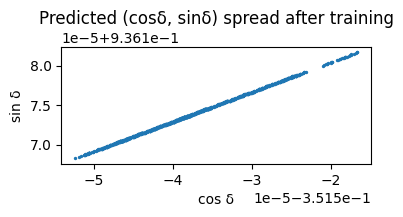

In [61]:
with torch.no_grad():
    outs = []
    for x, cond, y in val_loader:
        v = model(x.to(device), cond.to(device))
        v = F.normalize(v, dim=1)
        outs.append(v.cpu().numpy())
outs = np.concatenate(outs, axis=0)

plt.figure(figsize=(4,4))
plt.scatter(outs[:,0], outs[:,1], s=2)
plt.gca().set_aspect('equal')
plt.title("Predicted (cosδ, sinδ) spread after training")
plt.xlabel("cos δ"); plt.ylabel("sin δ")
plt.show()

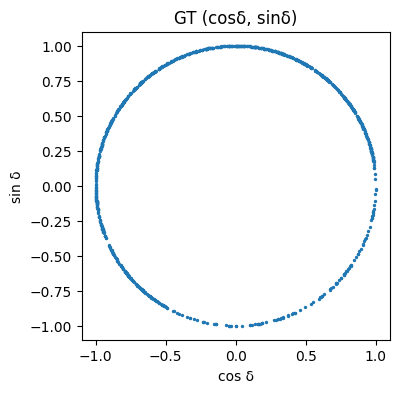

C:\Users\KOSJ\AppData\Local\Temp\ipykernel_25532\3411790884.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=dev

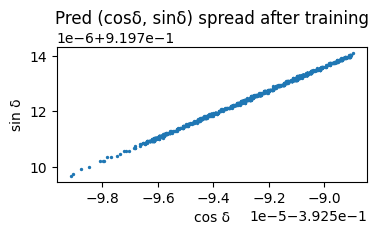

In [67]:
# ===================== Validation 분포 시각화 =====================
# GT scatter
ys = []
for _, _, y in val_loader:
    ys.append(y.cpu().numpy())          # 안전하게 .cpu()
ys = np.concatenate(ys, 0)

plt.figure(figsize=(4,4))
plt.scatter(ys[:,0], ys[:,1], s=2)
plt.gca().set_aspect('equal')
plt.title("GT (cosδ, sinδ)")
plt.xlabel("cos δ"); plt.ylabel("sin δ")
plt.show()

# Pred scatter  (🔸정규화해서 그리기!)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()
outs = []
with torch.no_grad():
    for x, cond, _ in val_loader:
        v = model(x.to(device), cond.to(device))
        v = torch.nn.functional.normalize(v, dim=1)   # 🔴 핵심: 예측을 유닛노름으로 정규화
        outs.append(v.cpu().numpy())
outs = np.concatenate(outs, 0)

plt.figure(figsize=(4,4))
plt.scatter(outs[:,0], outs[:,1], s=2)
plt.gca().set_aspect('equal')
plt.title("Pred (cosδ, sinδ) spread after training")
plt.xlabel("cos δ"); plt.ylabel("sin δ")
plt.show()

C:\Users\KOSJ\AppData\Local\Temp\ipykernel_25532\3707294392.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=dev

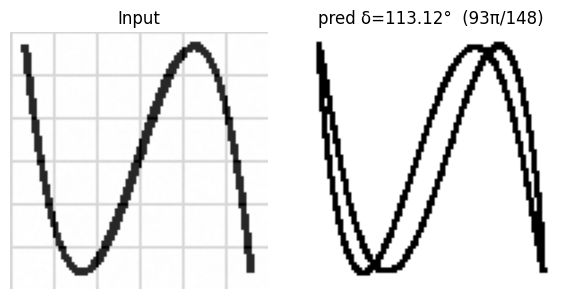

GT δ=239.55°  (177π/133)


In [69]:
# ---------------- Inference Helper ----------------
def predict_delta(model, img_gray_pil, a, b, side=SIDE, device=None):
    if device is None: device = next(model.parameters()).device
    img = normalize_to_square(img_gray_pil.convert('L').resize((side, side), Image.BILINEAR), side=side)
    x = preprocess_to_tensor(img).unsqueeze(0).to(device)
    cond = torch.tensor([[a/6.0,b/6.0]],dtype=torch.float32).to(device)
    with torch.no_grad():
        vec = model(x,cond); vec = F.normalize(vec, dim=1)
    delta = float(torch.atan2(vec[0,1], vec[0,0]).item() % (2*np.pi))
    return delta, img

# 합성 샘플로 sanity check
a,b = random.choice(RATIOS)
delta_gt = random.uniform(0, 2*np.pi)
img_syn = draw_curve(SIDE,a,b,delta_gt, thickness=2,
                     Ax=np.random.uniform(0.6,1.1), Ay=np.random.uniform(0.6,1.1))
img_syn = overlay_grid(add_noise(img_syn))
img_syn = normalize_to_square(img_syn, side=SIDE)

model.load_state_dict(torch.load(ckpt_path, map_location=device))
pred, viz = predict_delta(model, img_syn, a, b)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(viz, cmap='gray'); plt.title("Input"); plt.axis('off')
img_fit = draw_curve(SIDE, a, b, pred, thickness=2)
plt.subplot(1,2,2); plt.imshow(img_fit, cmap='gray'); 
plt.title(f"pred δ={np.degrees(pred):.2f}°  ({delta_to_pi_fraction(pred)})"); plt.axis('off')
plt.tight_layout(); plt.show()

print(f"GT δ={np.degrees(delta_gt):.2f}°  ({delta_to_pi_fraction(delta_gt)})")

✅ Loaded checkpoint: phase_cnn_best.pt


C:\Users\KOSJ\AppData\Local\Temp\ipykernel_25532\1182857570.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=devi

→ ratio = 1:3

===== Prediction on your image =====
ratio 1:3
δ ≈ 114.77°  (95π/149)   |   rad = 2.003027


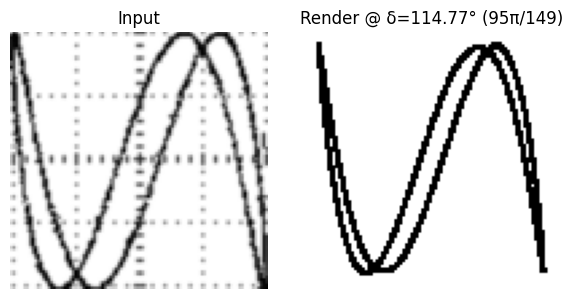

In [54]:
# ================= Inference on YOUR experiment image =================
import os, numpy as np, matplotlib.pyplot as plt
from PIL import Image

# 1) 체크포인트 로드(학습이 끝난 뒤 실행)
if os.path.exists(ckpt_path):
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    print(f"✅ Loaded checkpoint: {ckpt_path}")
else:
    print(f"⚠️ Checkpoint not found: {ckpt_path}  (학습 셀을 먼저 실행하세요)")

# 2) (a:b) 비 입력
def parse_ratio(s):
    s = s.strip()
    if ":" in s:
        a,b = s.split(":")
    else:
        a,b = s.split()  # "1 3" 형태 허용
    return int(a), int(b)

ratio_str = input("각진동수 비를 입력하세요 (예: 1:3) : ")
a, b = parse_ratio(ratio_str)
print(f"→ ratio = {a}:{b}")

# 3) 이미지 업로드/불러오기 (Colab/로컬 둘 다 지원)
try:
    from google.colab import files
    print("➡️ 실험 이미지 1장 업로드(.png/.jpg)")
    uploaded = files.upload()
    fname = next(iter(uploaded))
except Exception:
    fname = input("이미지 경로를 입력하세요 (예: ./my_lissajous.png) : ").strip()

img_in = Image.open(fname)

# 4) 예측 (cos/sin → atan2 복원)
pred_delta_rad, viz = predict_delta(model, img_in, a, b, side=SIDE, device=device)
pred_delta_deg = float(np.degrees(pred_delta_rad))
pi_txt = delta_to_pi_fraction(pred_delta_rad, max_den=180)

print("\n===== Prediction on your image =====")
print(f"ratio {a}:{b}")
print(f"δ ≈ {pred_delta_deg:.2f}°  ({pi_txt})   |   rad = {pred_delta_rad:.6f}")

# 5) 시각화: 입력(리사이즈) vs 예측 δ로 렌더
from PIL import ImageDraw
def draw_curve_quick(size, a, b, delta, thickness=2, margin=0.06):
    # 기존 draw_curve와 동일하지만 의존 최소화를 위해 재사용
    from math import sin
    img = Image.new('L', (size, size), 255)
    draw = ImageDraw.Draw(img)
    t = np.linspace(0, 2*np.pi, 1500)
    x = np.sin(a*t + delta); y = np.sin(b*t)
    x = x/(np.max(np.abs(x))+1e-9); y = y/(np.max(np.abs(y))+1e-9)
    s = int(size*(1-2*margin))
    px = ((x+1)/2 * s + size*margin)
    py = ((1-(y+1)/2) * s + size*margin)
    draw.line(list(zip(px, py)), fill=0, width=thickness, joint="curve")
    return img

img_fit = draw_curve_quick(SIDE, a, b, pred_delta_rad, thickness=2)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(viz.convert('L').resize((SIDE,SIDE)), cmap='gray'); plt.title("Input"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_fit, cmap='gray'); plt.title(f"Render @ δ={pred_delta_deg:.2f}° ({pi_txt})"); plt.axis('off')
plt.tight_layout(); plt.show()
